# Multi-model embeddings
In this notebook we will showcase the usage of multimodal embeddings using the new [voyage-multimodal-3](https://blog.voyageai.com/2024/11/12/voyage-multimodal-3/) all-in-one embedding model. This model allows us to store multimodal data within the same vector space. It is a state of the art I'm currently at the top of the benchmark list for a multimodal embedding retrieval.

In this example tutorial, we will focus on the following three main things:

- **Setting up a vector storage**, as most vector storage solutions are not yet supporting this model out of the box. We need to manually configure vector storage to be able to store these embeddings. We'll use Weaviate in this demo.

- **Storing embeddings of multimodal documents within this store**. To do this, we'll need to break apart the text and images within a single PDF file, store them as a JSON component, and then add them in a single vector space to the Weaviate store.

- **Performing a similarity search based on these stored images and embeddings**. We'll write a simple query to retrieve the most similar documents based on a natural language query.

To test this pipeline we'll use a PDF from an old Photography magazine located here [./files/magazine.pdf](./files/magazine.pdf).

### Requirements for this example

- **Weaviate**: We'll use the local Weaviate instance that is provided with the Docker Compose file.
- **Voyage API key**: You can get a free API key from [Voyage](https://voyageai.com/).
- **Poppler**: This utility is needed to extract the images from the PDF file. You can install it on MacOS with `brew install poppler`.

## Step 1: Setting up the vector storage
We will use weaviate in combinatation with the [voyage-multimodal-3](https://blog.voyageai.com/2024/11/12/voyage-multimodal-3/) model.

| Model | Context Length (tokens) | Embedding Dimension | Description |
|-------|------------------------|-------------------|-------------|
| voyage-multimodal-3 | 32,000 | 1024 | Rich multimodal embedding model that can vectorize interleaved text and content-rich images, such as screenshots of PDFs, slides, tables, figures, and more. See blog post for details. |


### Connect to Weaviate and create a new collection
In this first step we connect to a local Weaviate instance and then create a new collection named "multimodal". We don't configure a vectorizer for this collection since Weaviate does not support multimodal embeddings for the voyager model yet. 

In [132]:
import weaviate
from weaviate.classes.config import Configure

client = weaviate.connect_to_local()
collection_name = "multimodal"

client.collections.delete(collection_name)

try:
    client.collections.create(
        name=collection_name,
        vectorizer_config=Configure.Vectorizer.none() # Don't set a vectorizer for this collection
    )
    collection = client.collections.get(collection_name)
except Exception:
    collection = client.collections.get(collection_name)


## Step 2: Extracting documents and images from the PDF
For the extraction process we use the popular Unstructured library. What we do is we iterate through the PDF file using the `hi_res` strategy. We store the image data in the metadata as an image base 64 encoded string and the text content we will store in the page_content key. 

This step to work the [Poppler](https://poppler.freedesktop.org/) utility needs to be installed on your system or container. 

In [4]:
from unstructured.partition.auto import partition

elements = partition(
            filename="../files/magazine.pdf",
            strategy="hi_res",
            extract_image_block_types=["Image", "Table"],
            extract_image_block_to_payload=True)

In [23]:
from unstructured.chunking.title import chunk_by_title

chunks = chunk_by_title(elements)

In [136]:
from unstructured.staging.base import elements_from_base64_gzipped_json
import PIL.Image
import io
import base64

embedding_objects = []
embedding_metadatas = []

for chunk in chunks:
    embedding_object = []
    metedata_dict = {
        "text": chunk.to_dict()["text"],
        "filename": chunk.to_dict()["metadata"]["filename"],
        "page_number": chunk.to_dict()["metadata"]["page_number"],
        "last_modified": chunk.to_dict()["metadata"]["last_modified"],
        "languages": chunk.to_dict()["metadata"]["languages"],
        "filetype": chunk.to_dict()["metadata"]["filetype"]
    }
    embedding_object.append(chunk.to_dict()["text"])

    # Add the images to the embedding object
    if "orig_elements" in chunk.to_dict()["metadata"]:
        base64_elements_str = chunk.to_dict()["metadata"]["orig_elements"]
        eles = elements_from_base64_gzipped_json(base64_elements_str)
        image_data = []
        for ele in eles:
            if ele.to_dict()["type"] == "Image":
                base64_image = ele.to_dict()["metadata"]["image_base64"]
                image_data.append(base64_image)
                pil_image = PIL.Image.open(io.BytesIO(base64.b64decode(base64_image)))
                # Resize image if larger than 1000x1000 while maintaining aspect ratio
                if pil_image.size[0] > 1000 or pil_image.size[1] > 1000:
                    ratio = min(1000/pil_image.size[0], 1000/pil_image.size[1])
                    new_size = (int(pil_image.size[0] * ratio), int(pil_image.size[1] * ratio))
                    pil_image = pil_image.resize(new_size, PIL.Image.Resampling.LANCZOS)
                embedding_object.append(pil_image)

        metedata_dict["image_data"] = image_data


    embedding_objects.append(embedding_object)
    embedding_metadatas.append(metedata_dict)

In [137]:
embedding_objects[:3]

[['Discover how to add mo atmosphere to your land tape\n\nTHE ART TO CAPTURING. WILDLIFE ~*~\n\nLearn the techniques you need to getStunning pictures of wild animals\n\n"MACRO MASTERCLASS\n\nDiscover the joys of close-up photography with four easy Tirdhécts',
  <PIL.Image.Image image mode=RGB size=977x1000>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=427x176>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=488x121>],
 ['USING YOUR DIGITAL EDITION\n\nClick the page When zoomed to turn over in, drag to pan BY Mester tho artot black & whito Lear the aot widite photography. Macro projects The utimate gusdeto astrologeal OUTDOOR LANDSCAPE AND NATURE PHOTOGRAPHY OUTDOOR LANDSCAPE AND NATU = PHOTOGRAPHY Double click\n\nto zoom\n\nOUTDOOR LANDSCAPE AND NATURE PHOTOGRAPHY\n\nwww.digitalcameraworld.com\n\nLANDSCAPE AND NATURE PHOTOGRAPHY\n\n)',
  <PIL.Image.Image image mode=RGB size=1000x874>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=416x491>],
 ['any of u

In [138]:
embedding_metadatas[:3]

[{'text': 'Discover how to add mo atmosphere to your land tape\n\nTHE ART TO CAPTURING. WILDLIFE ~*~\n\nLearn the techniques you need to getStunning pictures of wild animals\n\n"MACRO MASTERCLASS\n\nDiscover the joys of close-up photography with four easy Tirdhécts',
  'filename': 'magazine.pdf',
  'page_number': 1,
  'last_modified': '2024-11-17T11:03:19',
  'languages': ['eng'],
  'filetype': 'application/pdf',
  'image_data': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAbcBrUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcIC

In [139]:
print(len(embedding_objects))
print(len(embedding_metadatas))

760
760


## Step 3: Vectorizing the extracted data
In this step we vectorize the extracted data using the Voyage API. We'll use the `voyage-multimodal-3` model to vectorize the text and images.
Per chunk of data we provide an array of inputs. In this case we provide an array of strings for the text and an array of PIL images for the images.

In [67]:
from dotenv import load_dotenv
import voyageai

load_dotenv()

vo = voyageai.Client()
# This will automatically use the environment variable VOYAGE_API_KEY.
# Alternatively, you can use vo = voyageai.Client(api_key="<your secret key>")

# Example input containing a text string and PIL image object
inputs = embedding_objects
# Vectorize inputs
result = vo.multimodal_embed(
    inputs, 
    model="voyage-multimodal-3",
    truncation=False
)

In [75]:
print(f"Shape of embeddings: {len(result.embeddings)}x{len(result.embeddings[0])}")

Shape of embeddings: 760x1024


## Step 4: Storing the embeddings in Weaviate

In [140]:
with collection.batch.dynamic() as batch:
    for i, data_row in enumerate(embedding_objects):
        batch.add_object(
            properties=embedding_metadatas[i],
            vector=result.embeddings[i]
        )

In [141]:
response = collection.query.fetch_objects(limit=1, include_vector=True)

for o in response.objects:
    print(o.metadata)
    print(o.properties)
    print(o.vector)

MetadataReturn(creation_time=None, last_update_time=None, distance=None, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None)
{'text': 'THE ONLY PHOTO GUIDE YOU NEED ON SALE NOW!\n\nAT WHSMITHS, BARNES & NOBLE AND OTHER SELECTED RETAIL OUTLETS\n\nae my magazines.co.uk/photo\n\nA SS t>\n\nQ ioShutter™ ee www.digitalcameraworld.com', 'image_data': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOlBloDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdh

## Step 5: Performing a similarity search and displaying the results

Portraits not only reveal every facial feature of the animal in great detail but also show its character in a way a more distant view can never achieve. Done well, animal portraits delve right into the soul of the subject; they make an emotional connection with the viewer through compelling eye contact; and they demand attention.

‘Allimages: MarkHamblin

Capture the magic of animals aswe rev al - 3 the key techniques and settings for wild >

_

_

.

ms

Core skills


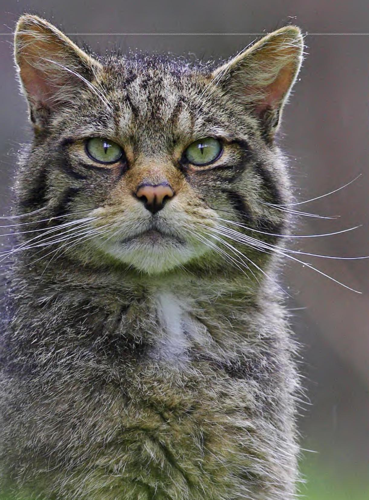

0.6223129034042358
HOW TO MAKE YOUR ANIMAL PORTRAITS ROAR

Check the background Once you've got your shot lined up, have a good look at the background before you start shooting, to make sure it complements the subject and there aren't any distractions.

Shoot head-on

Avoid compositions where part of the body is truncated on either side of the frame, as this will look odd. Instead, compose the shot so that you're viewing the subject chest-on, as this will present amore compact profile.


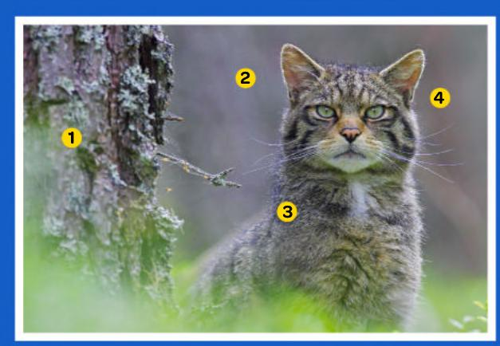

0.6615575551986694


In [151]:
from weaviate.classes.query import MetadataQuery

question = "What do magazines say about cats ?"
vector = vo.multimodal_embed([[question]], model="voyage-multimodal-3")

vector.embeddings[0]

response = collection.query.near_vector(
    near_vector=vector.embeddings[0], # your query vector goes here
    limit=2,
    return_metadata=MetadataQuery(distance=True)
)

for o in response.objects:
    print(o.properties['text'])
    for image_data in o.properties['image_data']:
        # Display the image using PIL
        img = PIL.Image.open(io.BytesIO(base64.b64decode(image_data)))
        width, height = img.size
        if width > 500 or height > 500:
            ratio = min(500/width, 500/height)
            new_size = (int(width * ratio), int(height * ratio))
            img = img.resize(new_size)
        display(img)
    print(o.metadata.distance)
